In [1]:
import pandas as pd
import panel as pn
import numpy as np
from sqlalchemy import create_engine
from datetime import date, timedelta
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set

pn.extension('tabulator')

engine = create_engine("mysql+pymysql://root:@localhost:3306/stock")
const = engine.connect()
engine = create_engine("sqlite:///c:\\ruby\\portmy\\db\\development.sqlite3")
conmy = engine.connect()

data_path = "../data/"
csv_path = "\\Users\\User\\iCloudDrive\\"
box_path = "\\Users\\User\\Dropbox\\"

today = date.today()
today

datetime.date(2022, 1, 18)

### Set today = last closed business day

In [2]:
today = today - timedelta(days=1)
today

datetime.date(2022, 1, 17)

### Restart and Run All Cells

In [3]:
sql = '''
UPDATE buy B
SET dividend =
(SELECT DIVIDEND FROM dividend D
WHERE B.name = D.name)'''
rp = const.execute(sql)
rp.rowcount

34

In [4]:
cols = 'name period shares price cost_amt base pct'.split()
colt = 'name shares unit_cost cost_amt price amount mkt_pct div_rnk amt_rnk div_amt'.split()

In [5]:
format_dict = {
    'shares':'{:,}','shares':'{:,}',    
    'price':'{:.2f}','unit_cost':'{:.2f}',
    'cost_amt':'{:,.2f}','div_amt':'{:,.2f}','amount':'{:,.2f}','profit':'{:,.2f}','base':'{:,.2f}',
    'dividend':'{:.4f}',    
    'pct':'{:,.2f}%','cost_pct':'{:,.2f}%','mkt_pct':'{:,.2f}%','pft_pct':'{:,.2f}%',
}

### Process portfolio (table buy in mysql stock)

In [6]:
sql = '''
SELECT name, volbuy AS shares, price AS unit_cost, volbuy * price AS cost_amt, dividend,
volbuy * dividend AS div_amt,  period
FROM buy
WHERE active = 1'''
print(sql)


SELECT name, volbuy AS shares, price AS unit_cost, volbuy * price AS cost_amt, dividend,
volbuy * dividend AS div_amt,  period
FROM buy
WHERE active = 1


In [7]:
df_buy = pd.read_sql(sql, const)
df_buy['shares'] = df_buy['shares'].astype('int64')
df_buy['cost_pct'] = round(df_buy['dividend'] / df_buy['unit_cost'] * 100,2)
df_buy.head().style.format(format_dict)

,name,shares,unit_cost,cost_amt,dividend,div_amt,period,cost_pct
0,STA,"20,000",34.75,"695,000.00",5.2500,"105,000.00",2,15.11%
1,RATCH,"9,000",45.75,"411,750.00",3.2500,"29,250.00",2,7.10%
2,IVL,"12,000",42.00,"504,000.00",0.8500,"10,200.00",3,2.02%
3,KCE,"6,000",85.00,"510,000.00",1.0000,"6,000.00",3,1.18%
4,MCS,"60,000",16.70,"1,002,000.00",1.3700,"82,200.00",2,8.20%


### Change period of stock in table buy

In [8]:
name = 'TOP'
sql = """
SELECT * 
FROM buy 
WHERE name = '%s' 
"""
sql = sql % name
df = pd.read_sql(sql, const)
df

,name,date,volbuy,price,volsell,volbal,active,dividend,period,grade
0,TOP,2021-11-26,3000.0,50.0,0.0,0.0,1,1.3,3,A4


In [9]:
sqlUpd = """
UPDATE buy
SET period = '3'
WHERE name = '%s' 
"""
sqlUpd = sqlUpd % name
print(sqlUpd)


UPDATE buy
SET period = '3'
WHERE name = 'TOP' 



In [10]:
rp = const.execute(sqlUpd)
rp.rowcount

1

In [11]:
file_name = 'hi-dividend.csv'
data_file = data_path + file_name
output_file = csv_path + file_name
box_file = box_path + file_name

df_buy.sort_values(['cost_pct'],ascending=[False]).to_csv(output_file)
df_buy.sort_values(['cost_pct'],ascending=[False]).to_csv(data_file)
df_buy.sort_values(['cost_pct'],ascending=[False]).to_csv(box_file)

### Start of Period Calculation

In [14]:
sql = '''
SELECT B.name, volbuy AS shares, B.price AS unit_cost, volbuy * B.price AS cost_amt, 
dividend, volbuy * dividend AS div_amt, 
FORMAT((volbuy * dividend)/(volbuy * B.price) * 100,1) AS cost_pct, 
P.price, volbuy * P.price AS amount, 
FORMAT((volbuy * dividend)/(volbuy * P.price) * 100,1) AS mkt_pct,
(P.price - B.price) * volbuy AS profit, 
FORMAT(((P.price - B.price) * volbuy) / (volbuy * B.price) * 100,1) AS pft_pct, period
FROM buy B JOIN price P
ON B.name = P.name
WHERE P.date = "%s"
AND active = 1'''
sql = sql % today 
print(sql)


SELECT B.name, volbuy AS shares, B.price AS unit_cost, volbuy * B.price AS cost_amt, 
dividend, volbuy * dividend AS div_amt, 
FORMAT((volbuy * dividend)/(volbuy * B.price) * 100,1) AS cost_pct, 
P.price, volbuy * P.price AS amount, 
FORMAT((volbuy * dividend)/(volbuy * P.price) * 100,1) AS mkt_pct,
(P.price - B.price) * volbuy AS profit, 
FORMAT(((P.price - B.price) * volbuy) / (volbuy * B.price) * 100,1) AS pft_pct, period
FROM buy B JOIN price P
ON B.name = P.name
WHERE P.date = "2022-01-17"
AND active = 1


In [15]:
df_buy_price = pd.read_sql(sql, const)
df_buy_price['shares'] = df_buy_price.shares.astype(int)
df_buy_price['mkt_pct'] = round(df_buy_price['dividend'] / df_buy_price['price'] * 100,2)
df_buy_price['cost_pct'] = round(df_buy_price['dividend'] / df_buy_price['unit_cost'] * 100,2)
df_buy_price['pft_pct'] = round((df_buy_price['price'] - df_buy_price['unit_cost']) / df_buy_price['unit_cost'] * 100,2)
df_buy_price.sort_values(['pft_pct'],ascending=[False]).head().style.format(format_dict)

,name,shares,unit_cost,cost_amt,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
2,IVL,"12,000",42.00,"504,000.00",0.8500,"10,200.00",2.02%,47.75,"573,000.00",1.78%,"69,000.00",13.69%,3
24,TSTH,"75,000",1.50,"112,500.00",nan,nan,nan%,1.63,"122,250.00",nan%,"9,750.00",8.67%,3
17,SIS,"4,500",40.50,"182,250.00",1.0000,"4,500.00",2.47%,43.75,"196,875.00",2.29%,"14,625.00",8.02%,3
31,RCL,"6,000",44.50,"267,000.00",3.5000,"21,000.00",7.87%,48.00,"288,000.00",7.29%,"21,000.00",7.87%,3
28,SYNEX,"4,500",31.50,"141,750.00",0.5800,"2,610.00",1.84%,33.75,"151,875.00",1.72%,"10,125.00",7.14%,3


In [16]:
df_buy_price.nlargest(5, 'mkt_pct')[['name','cost_amt','amount','div_amt','cost_pct','mkt_pct']].style.format(format_dict)

,name,cost_amt,amount,div_amt,cost_pct,mkt_pct
0,STA,"695,000.00","620,000.00","105,000.00",15.11%,16.94%
22,NOBLE,"441,000.00","400,050.00","53,550.00",12.14%,13.39%
6,TMT,"283,500.00","278,100.00","29,700.00",10.48%,10.68%
4,MCS,"1,002,000.00","894,000.00","82,200.00",8.20%,9.19%
12,JASIF,"1,000,000.00","1,070,000.00","95,000.00",9.50%,8.88%


In [17]:
df_buy_price.nsmallest(5, 'mkt_pct')[['name','cost_amt','amount','div_amt','cost_pct','mkt_pct']].style.format(format_dict)

,name,cost_amt,amount,div_amt,cost_pct,mkt_pct
11,DOHOME,"291,600.00","274,800.00","1,200.00",0.41%,0.44%
18,CKP,"150,000.00","153,000.00","1,050.00",0.70%,0.69%
33,IP,"212,100.00","198,450.00","1,942.50",0.92%,0.98%
29,BGRIM,"360,000.00","351,000.00","4,050.00",1.12%,1.15%
3,KCE,"510,000.00","492,000.00","6,000.00",1.18%,1.22%


In [18]:
file_name = 'buy-div-price.csv'
data_file = data_path + file_name
output_file = csv_path + file_name
box_file = box_path + file_name

df_buy_price.sort_values(['period','name'],ascending=[True,True]).to_csv(output_file)
df_buy_price.sort_values(['period','name'],ascending=[True,True]).to_csv(data_file)
df_buy_price.sort_values(['period','name'],ascending=[True,True]).to_csv(box_file)

### Short term stocks

In [19]:
short_term = df_buy_price.period == '4'
df_buy_price.loc[short_term].sort_values(['pft_pct'],ascending=[False]).style.format(format_dict)

,name,shares,unit_cost,cost_amt,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
26,KBANK,800,136.50,"109,200.00",3.0000,"2,400.00",2.20%,144.50,"115,600.00",2.08%,"6,400.00",5.86%,4
23,NER,"36,000",7.45,"268,200.00",0.2200,"7,920.00",2.95%,7.60,"273,600.00",2.89%,"5,400.00",2.01%,4
19,LPF,"10,000",14.00,"140,000.00",0.7565,"7,565.00",5.40%,14.00,"140,000.00",5.40%,0.00,0.00%,4
32,RJH,"4,500",33.00,"148,500.00",1.7000,"7,650.00",5.15%,33.00,"148,500.00",5.15%,0.00,0.00%,4
8,WHART,"10,000",12.50,"125,000.00",0.8298,"8,298.00",6.64%,12.30,"123,000.00",6.75%,"-2,000.00",-1.60%,4
20,TU,"18,000",20.80,"374,400.00",0.8500,"15,300.00",4.09%,20.30,"365,400.00",4.19%,"-9,000.00",-2.40%,4
29,BGRIM,"9,000",40.00,"360,000.00",0.4500,"4,050.00",1.12%,39.00,"351,000.00",1.15%,"-9,000.00",-2.50%,4


In [20]:
p4cost = df_buy_price.loc[short_term].cost_amt.sum()
p4profit = df_buy_price.loc[short_term].profit.sum()
p4pct = round(p4profit/p4cost*100, 2)
p4cost, p4profit, p4pct, df_buy_price.loc[short_term].shape[0]

(1525300.0, -8200.0, -0.54, 7)

### Long term stocks

In [21]:
long_term = df_buy_price.period == '3'
df_buy_price[long_term].sort_values(['pft_pct'],ascending=[False]).shape

(17, 13)

In [22]:
df_buy_price[long_term].nlargest(5, 'pft_pct')[['name','cost_amt','amount','profit','pft_pct']].style.format(format_dict)

,name,cost_amt,amount,profit,pft_pct
2,IVL,"504,000.00","573,000.00","69,000.00",13.69%
24,TSTH,"112,500.00","122,250.00","9,750.00",8.67%
17,SIS,"182,250.00","196,875.00","14,625.00",8.02%
31,RCL,"267,000.00","288,000.00","21,000.00",7.87%
28,SYNEX,"141,750.00","151,875.00","10,125.00",7.14%


In [23]:
p3cost = df_buy_price.loc[long_term].cost_amt.sum()
p3profit = df_buy_price.loc[long_term].profit.sum()
p3pct = round(p3profit/p3cost*100, 2)
p3cost, p3profit, p3pct,df_buy_price.loc[long_term].shape[0]

(4143800.0, 65450.0, 1.58, 17)

### High dividend stocks

In [24]:
hi_dividend = df_buy_price.period == '2'
df_buy_price.loc[hi_dividend].sort_values(['mkt_pct'],ascending=[False]).style.format(format_dict)

,name,shares,unit_cost,cost_amt,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
0,STA,"20,000",34.75,"695,000.00",5.2500,"105,000.00",15.11%,31.00,"620,000.00",16.94%,"-75,000.00",-10.79%,2
22,NOBLE,"63,000",7.00,"441,000.00",0.8500,"53,550.00",12.14%,6.35,"400,050.00",13.39%,"-40,950.00",-9.29%,2
6,TMT,"27,000",10.50,"283,500.00",1.1000,"29,700.00",10.48%,10.30,"278,100.00",10.68%,"-5,400.00",-1.90%,2
4,MCS,"60,000",16.70,"1,002,000.00",1.3700,"82,200.00",8.20%,14.90,"894,000.00",9.19%,"-108,000.00",-10.78%,2
12,JASIF,"100,000",10.00,"1,000,000.00",0.9500,"95,000.00",9.50%,10.70,"1,070,000.00",8.88%,"70,000.00",7.00%,2
16,HREIT,"30,000",8.95,"268,500.00",0.6932,"20,796.00",7.75%,8.90,"267,000.00",7.79%,"-1,500.00",-0.56%,2
5,DIF,"60,000",14.70,"882,000.00",1.0440,"62,640.00",7.10%,14.20,"852,000.00",7.35%,"-30,000.00",-3.40%,2
1,RATCH,"9,000",45.75,"411,750.00",3.2500,"29,250.00",7.10%,44.50,"400,500.00",7.30%,"-11,250.00",-2.73%,2
14,TISCO,"2,000",97.50,"195,000.00",6.3000,"12,600.00",6.46%,98.75,"197,500.00",6.38%,"2,500.00",1.28%,2


In [25]:
df_buy_price[hi_dividend].nlargest(5, 'mkt_pct')[['name','cost_amt','amount','div_amt','cost_pct','mkt_pct']]\
.style.format(format_dict)

,name,cost_amt,amount,div_amt,cost_pct,mkt_pct
0,STA,"695,000.00","620,000.00","105,000.00",15.11%,16.94%
22,NOBLE,"441,000.00","400,050.00","53,550.00",12.14%,13.39%
6,TMT,"283,500.00","278,100.00","29,700.00",10.48%,10.68%
4,MCS,"1,002,000.00","894,000.00","82,200.00",8.20%,9.19%
12,JASIF,"1,000,000.00","1,070,000.00","95,000.00",9.50%,8.88%


In [26]:
p2profit = df_buy_price.loc[hi_dividend].profit.sum()
p2cost = df_buy_price.loc[hi_dividend].cost_amt.sum()
p2dividend = df_buy_price.loc[hi_dividend].div_amt.sum()
p2yield = round(p2profit/p2cost*100,2)
p2cost, p2profit, p2yield, p2dividend, df_buy_price.loc[hi_dividend].shape[0]

(5178750.0, -199600.0, -3.85, 490736.0, 9)

### Disposal stocks

In [27]:
disposal = df_buy_price.period == '1'
df_buy_price.loc[disposal].sort_values(['pft_pct'],ascending=[True]).style.format(format_dict)

,name,shares,unit_cost,cost_amt,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
15,PTTGC,"6,000",64.75,"388,500.00",3.0000,"18,000.00",4.63%,59.50,"357,000.00",5.04%,"-31,500.00",-8.11%,1


In [28]:
p1cost = df_buy_price.loc[disposal].cost_amt.sum()
p1profit = df_buy_price.loc[disposal].profit.sum()
p1pct = round(p1profit/p1cost*100,2)
p1cost, p1profit, p1pct,df_buy_price.loc[disposal].shape[0]

(388500.0, -31500.0, -8.11, 1)

### Discrepancies calculation

In [29]:
sql = '''
SELECT *
FROM buy
WHERE active = 1'''
df = pd.read_sql(sql, const)
df['cost_amt'] = df.shares * df.price
df.shape

AttributeError: 'DataFrame' object has no attribute 'shares'

In [30]:
sql = '''
SELECT name, market
FROM stocks
ORDER BY name'''
my_stocks = pd.read_sql(sql, conmy)
my_stocks.shape

(359, 2)

In [31]:
filters = [
   (my_stocks.market.str.contains('SET50')),
   (my_stocks.market.str.contains('SET100')),
   (my_stocks.market.str.contains('mai'))    
]
values = [450000.0,300000.0,150000.0]

In [32]:
my_stocks["base"] = np.select(filters, values, default=150000)
my_stocks.head().style.format(format_dict)

,name,market,base
0,2S,SET,"150,000.00"
1,AAV,sSET / SETTHSI,"150,000.00"
2,ACE,SET100,"300,000.00"
3,ADVANC,SET50 / SETHD / SETTHSI,"450,000.00"
4,AEONTS,SET100,"300,000.00"


In [33]:
df_merge = pd.merge(df, my_stocks, on='name', how='inner')
df_merge.shape

(34, 12)

In [34]:

df_merge['pct'] = round(df_merge.cost_amt/df_merge.base*100,2)
df_merge['shares'] = df_merge['shares'].astype(int)
mask = df.period != '2'
df_merge[mask][cols].head().style.format(format_dict)

AttributeError: 'DataFrame' object has no attribute 'cost_amt'

In [35]:
df_merge[mask].nsmallest(3, 'pct')[cols].style.format(format_dict)

NameError: name 'mask' is not defined

In [36]:
df_merge[mask].nlargest(3, 'pct')[cols].style.format(format_dict)

NameError: name 'mask' is not defined

### Rank

In [37]:
df2 = df_buy_price[df_buy_price['period'] == '2'].copy()
df2['div_rnk'] = df2.mkt_pct.rank(ascending=False)
df2['amt_rnk'] = df2.amount.rank(ascending=False)
df2_out = df2[colt].sort_values('div_rnk')
df2_tab = pn.widgets.Tabulator(df2_out, layout='fit_data', width=900)
df2_tab

Tabulator(layout='fit_data', value=     name  shares  ..., width=900)

In [38]:
df2_out.div_amt.sum()

490736.0

In [39]:
df_buy_price.period.value_counts()

3    17
2     9
4     7
1     1
Name: period, dtype: int64

In [40]:
df_buy_price.period.value_counts(normalize=True).to_frame().style.format('{:.1%}')

,period
3,50.0%
2,26.5%
4,20.6%
1,2.9%


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


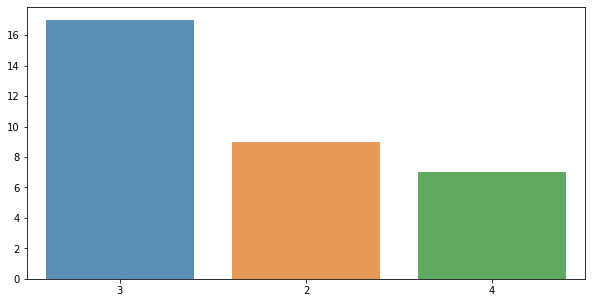

In [41]:
Period_Count =\
df_buy_price.period.value_counts(sort=True).nlargest(3)
plt.figure(figsize=(10,5))
sns.barplot(Period_Count.index,
Period_Count.values, alpha=0.8)
plt.show()

In [42]:
df9 = df_buy_price[df_buy_price['period'] != '2'].copy()
df9['div_rnk'] = df9.mkt_pct.rank(ascending=False)
df9['amt_rnk'] = df9.amount.rank(ascending=False)
df9_out = df9[colt].sort_values('div_rnk')
df9_tab = pn.widgets.Tabulator(df9_out, layout='fit_data', width=900)
df9_tab

Tabulator(layout='fit_data', value=      name  shares  ..., width=900)

In [43]:
df_buy_price.loc[short_term].head().style.format(format_dict)

,name,shares,unit_cost,cost_amt,dividend,div_amt,cost_pct,price,amount,mkt_pct,profit,pft_pct,period
8,WHART,"10,000",12.50,"125,000.00",0.8298,"8,298.00",6.64%,12.30,"123,000.00",6.75%,"-2,000.00",-1.60%,4
19,LPF,"10,000",14.00,"140,000.00",0.7565,"7,565.00",5.40%,14.00,"140,000.00",5.40%,0.00,0.00%,4
20,TU,"18,000",20.80,"374,400.00",0.8500,"15,300.00",4.09%,20.30,"365,400.00",4.19%,"-9,000.00",-2.40%,4
23,NER,"36,000",7.45,"268,200.00",0.2200,"7,920.00",2.95%,7.60,"273,600.00",2.89%,"5,400.00",2.01%,4
26,KBANK,800,136.50,"109,200.00",3.0000,"2,400.00",2.20%,144.50,"115,600.00",2.08%,"6,400.00",5.86%,4


In [44]:
data = df_buy_price.loc[short_term]
names = data['name']
in_p = ", ".join(map(lambda name: "'%s'" % name, names))
in_p

"'WHART', 'LPF', 'TU', 'NER', 'KBANK', 'BGRIM', 'RJH'"

In [45]:
sql = '''
SELECT name, min_price AS min, price, max_price AS max
FROM stocks
WHERE name IN (%s)'''
sql = sql % in_p
print(sql)

stocks = pd.read_sql(sql, conmy)
stocks.set_index('name',inplace=True)
stocks


SELECT name, min_price AS min, price, max_price AS max
FROM stocks
WHERE name IN ('WHART', 'LPF', 'TU', 'NER', 'KBANK', 'BGRIM', 'RJH')


,min,price,max
name,,,
BGRIM,38.25,39.0,55.00
KBANK,101.00,144.5,153.00
LPF,10.30,14.0,17.10
NER,4.54,7.6,8.65
RJH,23.90,33.0,39.00
TU,13.40,20.2,23.00
WHART,10.68,12.2,14.08


In [46]:
#stocks.drop('SCC',inplace=True)
#stocks

<AxesSubplot:xlabel='name'>

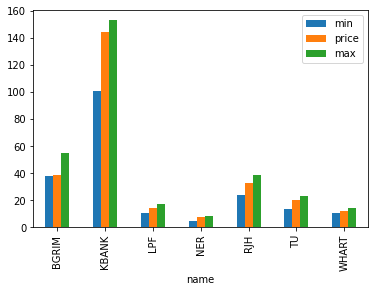

In [47]:
stocks.plot.bar()

In [48]:
#stocks.reset_index('name',inplace=True)
#sns.barplot(x='name', y='price', data=stocks)